## Dry bulk stocks mean reverting strategy

In this financial freight trading analysis, we will look at possible mean reverting strategies between dry bulk shipping stocks listed on the NYSE including the BDRY which is an ETF invested in derivatives such as forward freight agreement (FFA). Data is taken from Tiingo and analysis performed in Python.

### 1 Initial data preparation

In [1]:
# import basic packages for data preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt
from statistics import mode
import pandas_datareader as pdr

api_key = '484ed38cf23157af25ba88dfd698e7a470322cb5'

In [2]:
# set tickers of equity universe
tickers = ['BALT', 'BBLKF', 'BDRY', 'DRYS', 'DSX', 'EDRY', 'EGLE', 'EXMCQ', 'FREED', 'GLBS',
           'GNK', 'GOGL', 'NM', 'NMM', 'OCNF', 'PRGN', 'SALT', 'SB', 'SBLK', 'SHIP', 'TBSI']

print('There are {} tickers in total'.format(len(tickers)))

There are 21 tickers in total


In [3]:
# download data for each ticker and store in dict
quotes = {}
end_date = dt.date.today() - dt.timedelta(1)

for ticker in tickers:
    try:
        df = pdr.tiingo.TiingoDailyReader(ticker, end=end_date, api_key = api_key).read()
        quotes[ticker] = df   
    except:
        print('{} has no information'.format(ticker))

BALT has no information
EXMCQ has no information
OCNF has no information
PRGN has no information
TBSI has no information


In [4]:
# checking number of data points
print('Number of data points:')
for quote in quotes:
    print('{} has {} data points'.format(quote, len(quotes[quote])))

Number of data points:
BBLKF has 760 data points
BDRY has 768 data points
DRYS has 882 data points
DSX has 1258 data points
EDRY has 720 data points
EGLE has 1258 data points
FREED has 19 data points
GLBS has 1258 data points
GNK has 1258 data points
GOGL has 1258 data points
NM has 1258 data points
NMM has 1258 data points
SALT has 1258 data points
SB has 1258 data points
SBLK has 1258 data points
SHIP has 1258 data points


In [5]:
# check for stock splits
splits = []

for quote in quotes:
    if quotes[quote]['splitFactor'].sum() != len(quotes[quote]):
        splits.append(quote)
        print('{} had a stock split'.format(quote))

DRYS had a stock split
EGLE had a stock split
FREED had a stock split
GLBS had a stock split
GNK had a stock split
GOGL had a stock split
NM had a stock split
NMM had a stock split
SALT had a stock split
SBLK had a stock split
SHIP had a stock split


In [6]:
# create a datetimeindex with business days freq
index = pd.date_range('2015-09-28', end_date, freq='B')

# combine series to create asset price dataframe
data = pd.DataFrame(index=index)
data.index.name = 'date'

for quote in quotes:
    stock = pd.Series(quotes[quote]['adjClose']).reset_index(level=[0])
    stock.drop('symbol', axis=1, inplace=True)
    stock.rename(columns={'adjClose':quote}, inplace=True)
    stock.index = pd.to_datetime(stock.index.date)
    data = data.join(stock, on='date', how='left')
    
print(data)

            BBLKF   BDRY  DRYS   DSX  EDRY   EGLE  FREED  GLBS    GNK   GOGL  \
date                                                                           
2015-09-28    NaN    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN   
2015-09-29    NaN    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN   
2015-09-30    NaN    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN   
2015-10-01    NaN    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN   
2015-10-02    NaN    NaN   NaN   NaN   NaN    NaN    NaN   NaN    NaN    NaN   
...           ...    ...   ...   ...   ...    ...    ...   ...    ...    ...   
2021-04-05  0.008  18.21   NaN  2.96  8.38  34.02    NaN  4.56  10.08  6.765   
2021-04-06  0.008  17.57   NaN  3.03  8.50  34.49    NaN  4.52  10.45  6.890   
2021-04-07  0.008  16.97   NaN  3.12  8.45  36.43    NaN  4.52  10.81  7.110   
2021-04-08  0.008  16.53   NaN  3.14  9.03  36.63    NaN  4.55  10.81  7.050   
2021-04-09  0.008  17.52   NaN  3.12  9.

In [7]:
# checking for null values in the data frame
missing_values = data.isnull().sum()
print(missing_values)

BBLKF     685
BDRY      677
DRYS      563
DSX       187
EDRY      725
EGLE      187
FREED    1426
GLBS      187
GNK       187
GOGL      187
NM        187
NMM       187
SALT      187
SB        187
SBLK      187
SHIP      187
dtype: int64


In [8]:
# check to see if values are systematically missing on certain days
missing = []

for ticker in data.columns:
    if data[ticker].isnull().sum() == mode(missing_values):
        missing.append(ticker)
        
missing_days = list(data[missing[0]][data[missing[0]].isnull()].index)
        
for value in missing:
    if list(data[value][data[value].isnull()].index) == missing_days:
        pass
    else:
        print('{} does not have the same missing values as {}'.format(value, missing[0]))

print('Stocks in list {} have the same missing days.'.format(missing))

Stocks in list ['DSX', 'EGLE', 'GLBS', 'GNK', 'GOGL', 'NM', 'NMM', 'SALT', 'SB', 'SBLK', 'SHIP'] have the same missing days.


### Discussion 1

We started our analysis with 21 shipping tickers in mind starting 28 Sep 2015 but had to drop 5 after failing to pull information from the server possibily due to stock delisting or simply information unavailability from Tiingo.

Missing values were introduced into the tickers' price series when we created a dataframe using customized datetime index with business days frequency.

Apart from these created missing values, there were other intrinsically unavailable values in BBLKF, BDRY, DRYS, EDRY and FREED. Among these 5 tickers, **FREED** only has 19 values and a vast majority of the total number of data points were missing. As such, this ticker will be dropped from our analysis.

Further research also revealed that both **DRYS** and **BBLKF** have been delisted which explains their missing values in more recent periods. As we are only interested in stocks currently traded on public exchanges, both were also be dropped from the analysis. **EDRY** was founded only in 2018 and lacked historical data compared to its peers and hence will also be dropped.  

Finally, **BDRY** being the only ETF that holds freight derivatives and also forms a central asset in our analysis, will be kept in the dataframe despite having a significant number of values missing due to its relatively short trading history. 

As such, we are now left with only 12 tickers in total.

In [9]:
# dropping columns as discussed above
drop_tickers = [ticker for ticker in data.columns if ticker not in missing]
clean = data.copy()
clean.drop(drop_tickers, axis=1, inplace=True)

# filling the gaps that were created
clean.fillna(method='ffill', inplace=True)

clean.tail()

,DSX,EGLE,GLBS,GNK,GOGL,NM,NMM,SALT,SB,SBLK,SHIP
date,,,,,,,,,,,
2021-04-05,2.96,34.02,4.56,10.08,6.765,9.13,22.68,21.36,2.37,14.22,1.0500
2021-04-06,3.03,34.49,4.52,10.45,6.890,9.98,24.99,21.88,2.35,14.36,1.0100
2021-04-07,3.12,36.43,4.52,10.81,7.110,10.13,27.10,21.70,2.35,14.69,1.0200
2021-04-08,3.14,36.63,4.55,10.81,7.050,11.01,27.71,20.67,2.26,14.74,0.9979
2021-04-09,3.12,36.35,4.58,10.86,7.160,10.52,26.34,20.44,2.24,14.77,0.9561


In [10]:
# adding back BDRY ETF
clean['BDRY'] = data['BDRY']

# rounding price data to 2 decimal places
clean = clean.round(2)
clean.tail()

,DSX,EGLE,GLBS,GNK,GOGL,NM,NMM,SALT,SB,SBLK,SHIP,BDRY
date,,,,,,,,,,,,
2021-04-05,2.96,34.02,4.56,10.08,6.76,9.13,22.68,21.36,2.37,14.22,1.05,18.21
2021-04-06,3.03,34.49,4.52,10.45,6.89,9.98,24.99,21.88,2.35,14.36,1.01,17.57
2021-04-07,3.12,36.43,4.52,10.81,7.11,10.13,27.10,21.70,2.35,14.69,1.02,16.97
2021-04-08,3.14,36.63,4.55,10.81,7.05,11.01,27.71,20.67,2.26,14.74,1.00,16.53
2021-04-09,3.12,36.35,4.58,10.86,7.16,10.52,26.34,20.44,2.24,14.77,0.96,17.52


In [11]:
# saving file to csv for future analysis
clean.to_csv(r'C:\Users\RyanK\Documents\Python Scripts\freight.csv')

### 2 Exploratory data analysis

After downloading the data from Tiingo and removing the missing data points, we now have a file containing all the time series price information that we need to perform further analysis. Before we go into statistical analysis, we will perform an EDA to get to understand our data better.

In [12]:
# import basic packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# load data from previously saved file
clean = pd.read_csv(r'C:\Users\RyanK\Documents\Python Scripts\freight.csv', parse_dates=True, index_col='date')
clean.index.freq = 'B'
clean.tail()

,DSX,EGLE,GLBS,GNK,GOGL,NM,NMM,SALT,SB,SBLK,SHIP,BDRY
date,,,,,,,,,,,,
2021-04-05,2.96,34.02,4.56,10.08,6.76,9.13,22.68,21.36,2.37,14.22,1.05,18.21
2021-04-06,3.03,34.49,4.52,10.45,6.89,9.98,24.99,21.88,2.35,14.36,1.01,17.57
2021-04-07,3.12,36.43,4.52,10.81,7.11,10.13,27.10,21.70,2.35,14.69,1.02,16.97
2021-04-08,3.14,36.63,4.55,10.81,7.05,11.01,27.71,20.67,2.26,14.74,1.00,16.53
2021-04-09,3.12,36.35,4.58,10.86,7.16,10.52,26.34,20.44,2.24,14.77,0.96,17.52


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


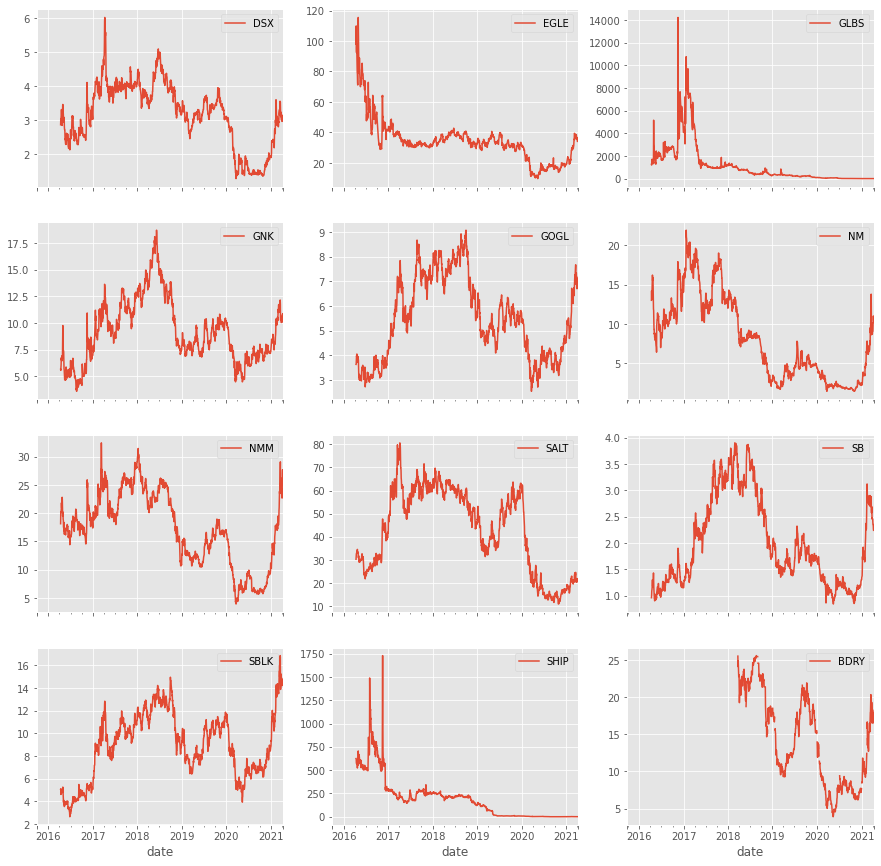

In [14]:
# plot individual price time series
print(plt.style.available)
plt.style.use('ggplot')

fig, ax = plt.subplots(4, 3, sharex=True, figsize=(15,15))

for i in range(4):
    for j in range(3):
        col = clean.columns[(i+j)+(i*2)]
        clean[col].plot(ax=ax[i,j], label=col)
        ax[i,j].legend()

plt.show()

In [15]:
# percent drop in value from peak to current
loss = (clean.max() - clean.iloc[-1])/clean.max()

for ticker in clean.columns:
    max_date = clean[ticker][clean[ticker] == clean[ticker].max()].index.strftime("%B %d, %Y")[0]
    max_loss = round(loss[ticker], 2)*100
    print('{} lost {}% of its value from its peak on {}'.format(ticker, max_loss, max_date))

DSX lost 48.0% of its value from its peak on April 10, 2017
EGLE lost 69.0% of its value from its peak on April 29, 2016
GLBS lost 100.0% of its value from its peak on November 16, 2016
GNK lost 42.0% of its value from its peak on June 08, 2018
GOGL lost 21.0% of its value from its peak on October 02, 2018
NM lost 52.0% of its value from its peak on January 23, 2017
NMM lost 19.0% of its value from its peak on March 13, 2017
SALT lost 75.0% of its value from its peak on April 06, 2017
SB lost 43.0% of its value from its peak on February 26, 2018
SBLK lost 12.0% of its value from its peak on March 19, 2021
SHIP lost 100.0% of its value from its peak on November 16, 2016
BDRY lost 32.0% of its value from its peak on August 21, 2018


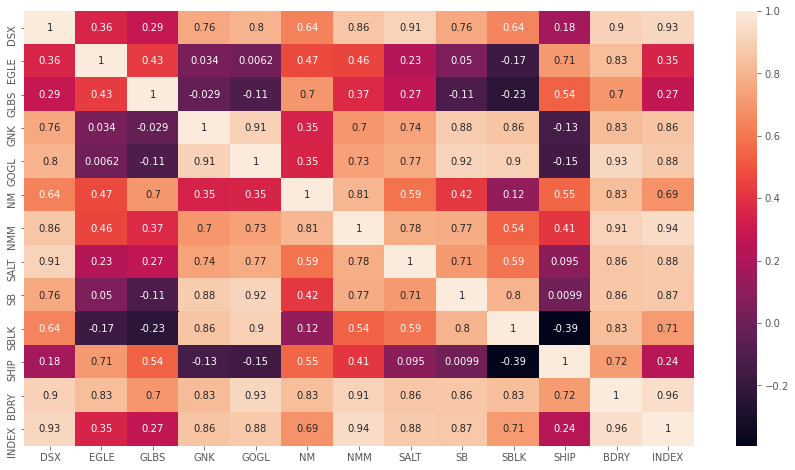

In [16]:
# scaling prices due to large difference across stocks
clean_scaled = clean.apply(lambda x: (x-x.min())/(x.max()-x.min()))

# creating a price weighted equity index excl. BDRY ETF
clean_scaled['INDEX'] = clean_scaled.iloc[:,1:].apply(np.mean, axis=1)

# plotting the correlation between stocks
import seaborn as sns

corr_df = clean_scaled.corr()
fig = plt.figure(figsize=(15,8))
sns.heatmap(corr_df, annot=True)

plt.show()

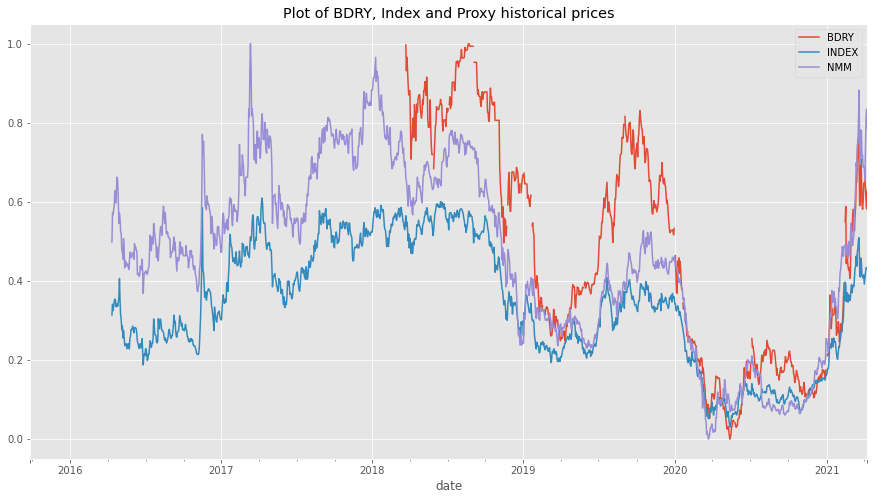

In [17]:
# stock most correlated to index is a proxy
proxy = corr_df['INDEX'].sort_values(ascending=False).index[2]

# plotting proxy, INDEX and BDRY for comparison
clean_scaled[['BDRY', 'INDEX', proxy]].plot(figsize=(15,8))
plt.title('Plot of BDRY, Index and Proxy historical prices')

plt.show()

### Discussion 2

Using the index as a guage for the shipping market, stocks in this sector lost a significant portion of their value in 2016 which coincided with end of the commodities super cycle. The index subsequently recovered through to mid 2018 before returning all its gains begining 2019.

From the correlation heatmap, we can see that shipping stocks are highly correlated to one another. Futher, the correlation between the price weighted index and NMM is 0.94 - suggesting that NMM could be a good proxy for the general performance of shipping stocks.

We will next consider a mean reverting strategy by trading the NMM and BDRY pair (since NMM has a 94% correlation with the index and is more cost efficient to trade). An index arbitrage for our basket of shares may also be considered and will be studied in future studies.

### 3 BDRY and proxy pair trading strategy

In [18]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

# finding the hedge ratio using EG test
bdry = clean['BDRY'].dropna()
stock = clean[proxy][bdry.index]

model1 = OLS(stock.values, bdry.values).fit()
print('Model 1 (BDRY as independent variable) coefficient: {}'.format(round(model1.params[0],2)))
print('\n')

adf1 = adfuller(model1.resid)
print('The adfuller test statistic for Model 1')
print(adf1)
print('\n')

model2 = OLS(bdry.values, stock.values).fit()
print('Model 2 (Proxy as independent variable) coefficient: {}'.format(round(model2.params[0],2)))
print('\n')

adf2 = adfuller(model2.resid)
print('The adfuller test statistic for Model 2')
print(adf2)

Model 1 (BDRY as independent variable) coefficient: 1.0


The adfuller test statistic for Model 1
(-2.218616849590625, 0.19955812924469218, 3, 764, {'1%': -3.438938229437747, '5%': -2.8653304587462944, '10%': -2.568788425002056}, 1514.5475889846946)


Model 2 (Proxy as independent variable) coefficient: 0.98


The adfuller test statistic for Model 2
(-2.282419160341417, 0.1777008477375981, 3, 764, {'1%': -3.438938229437747, '5%': -2.8653304587462944, '10%': -2.568788425002056}, 1497.331456519268)


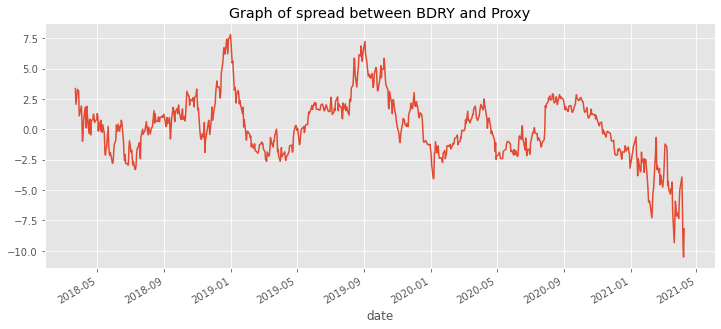

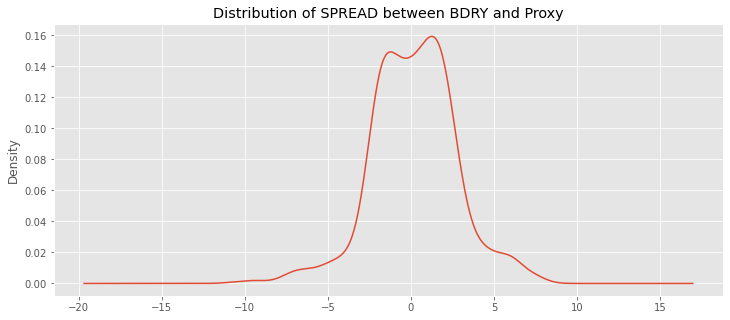

count    768.000000
mean       0.187852
std        2.557091
min      -10.516069
25%       -1.456866
50%        0.225644
75%        1.809431
max        7.799726
dtype: float64


In [19]:
# finding the hedge ratio
coef1 = model1.params[0]
coef2 = model2.params[0]
hedge_ratio = np.where(coef1<coef2, coef1, coef2)

# plot the spread between BDRY and the proxy
pair = clean[['BDRY', proxy]].copy()
pair = pair.dropna(subset=['BDRY'])
pair['spread'] = pair['BDRY'] - hedge_ratio*pair[proxy]

pair['spread'].plot(figsize=(12,5))
plt.title('Graph of spread between BDRY and Proxy')

plt.show()

# plot the distribution of the spread
resid = pd.Series(model2.resid)

resid.plot(kind='kde', figsize=(12,5))
plt.title('Distribution of SPREAD between BDRY and Proxy')

plt.show()

print(resid.describe())

In [20]:
# setting up bollinger bands
rolling = 5

# moving average and moving standard deviation
pair['moving_ave'] = pair['spread'].rolling(rolling).mean()
pair['moving_std'] = pair['spread'].rolling(rolling).std()

# upper band and lower band
pair['upper_band'] = pair['moving_ave'] + 0.5*pair['moving_std']
pair['lower_band'] = pair['moving_ave'] - 0.5*pair['moving_std']

#pair.tail()

In [21]:
# setup long entry/exit
pair['long_entry'] = pair['spread'] < pair['lower_band']
pair['long_exit'] = pair['spread'] >= pair['moving_ave']

# setup short entry/exit
pair['short_entry'] = pair['spread'] > pair['upper_band']
pair['short_exit'] = pair['spread'] <= pair['moving_ave']

#pair.tail()

In [22]:
# consolidating long/short positions
pair['pos_long'] = np.nan
pair.loc[pair['long_entry'], 'pos_long'] = 1
pair.loc[pair['long_exit'], 'pos_long'] = 0

pair['pos_short'] = np.nan
pair.loc[pair['short_entry'], 'pos_short'] = -1
pair.loc[pair['short_exit'], 'pos_short'] = 0

# filling values between entry/exit
pair = pair.fillna(method='ffill')

# combine long/short positions
pair['positions'] = pair['pos_long'] + pair['pos_short']

#pair.tail()

In [23]:
# calculate daily portfolio value
pair['portfolio_value'] = pair['BDRY'] + abs(hedge_ratio) * pair[proxy]

# calculate spread difference
pair['spread_diff'] = pair['spread'].diff()

# calculate daily return
pair['daily_returns'] = pair['spread_diff'] / pair['portfolio_value'].shift()

#pair.tail()

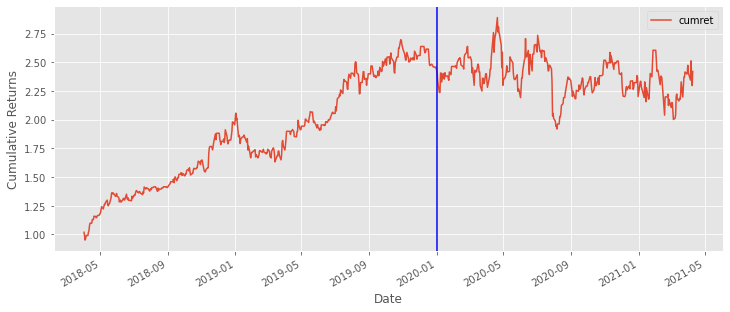

In [24]:
# calculate strategy returns
pair['strategy_returns'] = pair['positions'].shift() * pair['daily_returns']

# calculate cumulative strategy returns
pair['cumret'] = (pair['strategy_returns']+1).cumprod()

# Plot cumulative returns
pair['cumret'].plot(figsize=(12,5))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.legend()

plt.axvline('2020-01', c='blue')

plt.show()

### Discussion 3

We discussed 2 models in this section used to determine the more appropreiate hedge ratio. Model 1 uses BDRY as the independent variable while model 2 the proxy as the independent variable. The coefficient of model 2 was used as the hedge ratio for this strategy as its adfuller test statistic was very slightly more statistically significant. Plotting the spread using the coefficient of model 2 also gave us a sationary time series until Sep-2020. We then went on to build a trading system using bollinger bands based on 0.5 standard devations. The result as shown above is very positive right up to the pandemic period of early 2020 before the strategy broke down - this could imply a regime change which warrants further investigation before employing this strategy again. It is possible that a momentum strategy may become more suitable from this point on which will be investigated in subsequent studies.